# Random Forest Analysis of Cozie Data Tier 2
- V16
- Tier2 data only
- Using continuous data instead of cluster thus avoiding the hot encoding


In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
from datetime import datetime
import os

# Preperation
from sklearn.model_selection import train_test_split

# Modeling
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans

# Visualisations
from sklearn.tree import export_graphviz # Note that you need to brew install graphviz on your local machine
import pydot 
import seaborn as sns
import matplotlib.pyplot as plt


# Evaluation
from sklearn import metrics

# User Defined Functions
import cozie_functions

In [2]:
# Add Data Folder to Path
data_path = os.path.abspath(os.path.join(os.path.dirname( "__file__" ), '..', 'data'))

# Reading Data
In this case we are first reading the data, and then reorganising them into groups. 
- First drop all unecessary data
- Then drop all Sensing Data
- Then drop all mbient Data

Afterwards, created normalised datasets of the average value. See `cozie_functions.py`

In [3]:
# The following participants took part in the experiment:
participant_ids = ['cresh' + str(id).zfill(2) for id in range(1,31)]
print(participant_ids)

['cresh01', 'cresh02', 'cresh03', 'cresh04', 'cresh05', 'cresh06', 'cresh07', 'cresh08', 'cresh09', 'cresh10', 'cresh11', 'cresh12', 'cresh13', 'cresh14', 'cresh15', 'cresh16', 'cresh17', 'cresh18', 'cresh19', 'cresh20', 'cresh21', 'cresh22', 'cresh23', 'cresh24', 'cresh25', 'cresh26', 'cresh27', 'cresh28', 'cresh29', 'cresh30']


In [4]:

feature_set_df = pd.read_csv(os.path.join(data_path, '2019-11-15_cozie_full_masked.csv'))
feature_set_df.drop(['Unnamed: 0', 'index', 'comfort_cozie', 'Space_id', 'Longitude',
                     'Latitude', 'co2_sensing', 'voc_sensing', 'Floor', 'lat_cozie', 'lon_cozie', 'responseSpeed_cozie'], axis=1, inplace=True)

feature_set_df.dropna(subset=['thermal_cozie','light_cozie','noise_cozie', 
                              'temperature_sensing', 'temperature_mbient', 
                              'heartRate_cozie'], inplace=True)

# Drop User's that were trialing and not in the experiment
feature_set_df = feature_set_df[feature_set_df.user_id.isin(participant_ids)]

#feature_set_df["thermal_cozie"] = feature_set_df["thermal_cozie"].astype(str)

In [5]:
## Added in V4

#feature_set_df.drop(["noise_cozie", "light_cozie"], axis=1, inplace=True)



feature_set_df.head()

,time,clothing,heartRate_cozie,light_cozie,noise_cozie,thermal_cozie,user_id,room,humidity_sensing,light_sensing,noise_sensing,temperature_sensing,temperature_mbient
118,2019-10-04 05:20:19.351000+00:00,11.0,70.0,10.0,10.0,10.0,cresh07,4.0,54.3496,74.0,46.0,23.7510,26.375
120,2019-10-04 05:21:01.479000+00:00,10.0,83.0,10.0,10.0,11.0,cresh10,4.0,54.3496,74.0,46.0,23.7510,26.750
122,2019-10-04 05:30:27.209000+00:00,11.0,61.0,10.0,10.0,10.0,cresh07,4.0,54.4616,71.0,46.0,23.6015,26.250
123,2019-10-04 05:30:59.243000+00:00,10.0,92.0,10.0,10.0,11.0,cresh10,4.0,54.4616,71.0,46.0,23.6015,26.250
124,2019-10-04 05:51:17.360000+00:00,11.0,70.0,10.0,10.0,10.0,cresh07,4.0,54.8265,73.0,47.0,23.5289,25.250


In [6]:
feature_set_df.describe()

,clothing,heartRate_cozie,light_cozie,noise_cozie,thermal_cozie,room,humidity_sensing,light_sensing,noise_sensing,temperature_sensing,temperature_mbient
count,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000
mean,9.445047,80.249661,9.930122,10.165536,10.091588,7.807327,66.955686,183.687246,51.729986,26.563384,28.814620
std,0.581480,14.558870,0.471742,0.371790,0.596798,4.712313,10.877362,239.344889,7.430901,1.646008,1.405592
min,9.000000,51.000000,9.000000,10.000000,9.000000,0.000000,51.030800,11.000000,41.000000,21.658800,23.875000
25%,9.000000,70.000000,10.000000,10.000000,10.000000,4.000000,59.022500,48.000000,46.000000,25.305900,28.125000
50%,9.000000,79.000000,10.000000,10.000000,10.000000,7.000000,62.266200,89.000000,49.000000,26.820900,28.750000
75%,10.000000,90.000000,10.000000,10.000000,10.000000,14.000000,76.870400,217.750000,54.000000,27.633200,29.750000
max,11.000000,149.000000,11.000000,11.000000,11.000000,16.000000,98.682200,1294.000000,72.000000,33.076900,32.875000


In [7]:
prefer_cooler_df = feature_set_df[feature_set_df["thermal_cozie"] == 11]
thermal_comfy_df = feature_set_df[feature_set_df["thermal_cozie"] == 10]
prefer_warmer_df = feature_set_df[feature_set_df["thermal_cozie"] == 9]

prefer_dimmer_df = feature_set_df[feature_set_df["light_cozie"] == 11]
visually_comfy_df = feature_set_df[feature_set_df["light_cozie"] == 10]
prefer_brighter_df = feature_set_df[feature_set_df["light_cozie"] == 9]

prefer_quieter_df = feature_set_df[feature_set_df["noise_cozie"] == 11]
aurally_comfy_df = feature_set_df[feature_set_df["noise_cozie"] == 10]
prefer_louder_df = feature_set_df[feature_set_df["noise_cozie"] == 9]

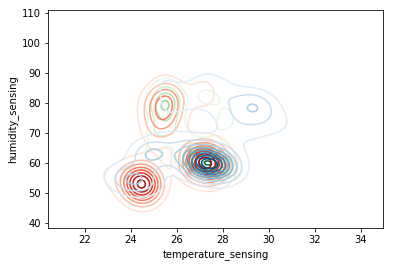

In [8]:

ax = sns.kdeplot(thermal_comfy_df.temperature_sensing, thermal_comfy_df.humidity_sensing,
                 cmap="Greens")
ax = sns.kdeplot(prefer_warmer_df.temperature_sensing, prefer_warmer_df.humidity_sensing,
                 cmap="Reds",)
ax = sns.kdeplot(prefer_cooler_df.temperature_sensing, prefer_cooler_df.humidity_sensing,
                 cmap="Blues")

In [9]:
feature_set_df.describe()

,clothing,heartRate_cozie,light_cozie,noise_cozie,thermal_cozie,room,humidity_sensing,light_sensing,noise_sensing,temperature_sensing,temperature_mbient
count,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000,1474.000000
mean,9.445047,80.249661,9.930122,10.165536,10.091588,7.807327,66.955686,183.687246,51.729986,26.563384,28.814620
std,0.581480,14.558870,0.471742,0.371790,0.596798,4.712313,10.877362,239.344889,7.430901,1.646008,1.405592
min,9.000000,51.000000,9.000000,10.000000,9.000000,0.000000,51.030800,11.000000,41.000000,21.658800,23.875000
25%,9.000000,70.000000,10.000000,10.000000,10.000000,4.000000,59.022500,48.000000,46.000000,25.305900,28.125000
50%,9.000000,79.000000,10.000000,10.000000,10.000000,7.000000,62.266200,89.000000,49.000000,26.820900,28.750000
75%,10.000000,90.000000,10.000000,10.000000,10.000000,14.000000,76.870400,217.750000,54.000000,27.633200,29.750000
max,11.000000,149.000000,11.000000,11.000000,11.000000,16.000000,98.682200,1294.000000,72.000000,33.076900,32.875000


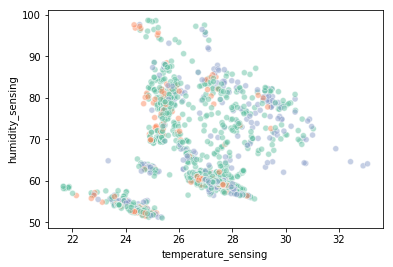

In [10]:
palette=sns.color_palette("Set2", 3)
ax = sns.scatterplot(x=feature_set_df.temperature_sensing, y=feature_set_df.humidity_sensing,
               hue=feature_set_df["thermal_cozie"], palette= [palette[1],palette[0],palette[2]], alpha = 0.5, legend = False)
plt.savefig("temp_hum_scatter.pdf")

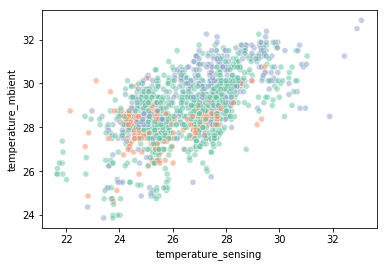

In [11]:
palette=sns.color_palette("Set2", 3)
ax = sns.scatterplot(x=feature_set_df.temperature_sensing, y=feature_set_df.temperature_mbient,
               hue=feature_set_df["thermal_cozie"], palette= [palette[1],palette[0],palette[2]], alpha = 0.5, legend = False)
plt.savefig("temp_temp_scatter.pdf")

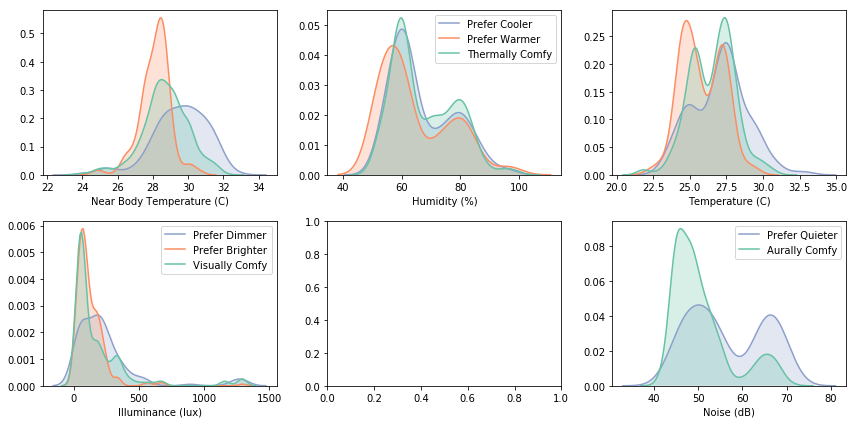

In [12]:


fig1, axes = plt.subplots(2, 3, figsize=(12, 6))


palette=sns.color_palette("Set2", 3)

#Plot Mbient
sns.kdeplot(prefer_cooler_df["temperature_mbient"], shade=True, color=palette[2], label = "Prefer Cooler", ax=axes[0,0])
sns.kdeplot(prefer_warmer_df["temperature_mbient"], shade=True, color=palette[1], label = "Prefer Warmer", ax=axes[0,0])
sns.kdeplot(thermal_comfy_df["temperature_mbient"], shade=True, color=palette[0], label = "Thermally Comfy", ax=axes[0,0])

# Plot Sensing 
sns.kdeplot(prefer_cooler_df["humidity_sensing"], shade=True, color=palette[2], label = "Prefer Cooler", ax=axes[0,1])
sns.kdeplot(prefer_warmer_df["humidity_sensing"], shade=True, color=palette[1], label = "Prefer Warmer", ax=axes[0,1])
sns.kdeplot(thermal_comfy_df["humidity_sensing"], shade=True, color=palette[0], label = "Thermally Comfy", ax=axes[0,1])


sns.kdeplot(prefer_cooler_df["temperature_sensing"], shade=True, color=palette[2], label = "Prefer Cooler", ax=axes[0,2])
sns.kdeplot(prefer_warmer_df["temperature_sensing"], shade=True, color=palette[1], label = "Prefer Warmer", ax=axes[0,2])
sns.kdeplot(thermal_comfy_df["temperature_sensing"], shade=True, color=palette[0], label = "Thermally Comfy", ax=axes[0,2])


# Sensing Light
sns.kdeplot(prefer_dimmer_df["light_sensing"], shade=True, color=palette[2], label = "Prefer Dimmer", ax=axes[1,0])
sns.kdeplot(prefer_brighter_df["light_sensing"], shade=True, color=palette[1], label = "Prefer Brighter", ax=axes[1,0])
sns.kdeplot(visually_comfy_df["light_sensing"], shade=True, color=palette[0], label = "Visually Comfy", ax=axes[1,0])

sns.kdeplot(prefer_quieter_df["noise_sensing"], shade=True, color=palette[2], label = "Prefer Quieter", ax=axes[1,2])
sns.kdeplot(prefer_louder_df["noise_sensing"], shade=True, color=palette[1], label = "Prefer Louder", ax=axes[1,2])
sns.kdeplot(aurally_comfy_df["noise_sensing"], shade=True, color=palette[0], label = "Aurally Comfy", ax=axes[1,2])


axes[0,0].set_xlabel('Near Body Temperature (C)')
axes[0,1].set_xlabel('Humidity (%)')
axes[0,2].set_xlabel('Temperature (C)')
axes[1,0].set_xlabel('Illuminance (lux)')
axes[1,2].set_xlabel('Noise (dB)')
fig1.tight_layout()

axes[0,0].get_legend().remove()
#axes[0,1].get_legend().remove()
axes[0,2].get_legend().remove()
#sns.kdeplot(x, bw=.2, label="bw: 0.2")
#sns.kdeplot(x, bw=2, label="bw: 2")
#plt.legend();

plt.savefig("DensityPlots.pdf")

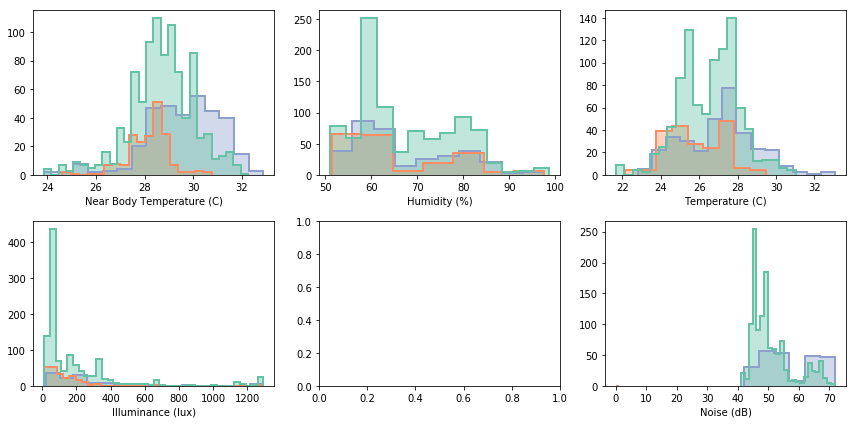

In [13]:
fig1, axes = plt.subplots(2, 3, figsize=(12, 6))


palette=sns.color_palette("Set2", 3)

#Plot Mbient
sns.distplot(prefer_cooler_df["temperature_mbient"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,0], rug=False)
sns.distplot(prefer_warmer_df["temperature_mbient"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,0], rug=False)
sns.distplot(thermal_comfy_df["temperature_mbient"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,0], rug=False)

# Plot Sensing 
sns.distplot(prefer_cooler_df["humidity_sensing"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,1], rug=False)
sns.distplot(prefer_warmer_df["humidity_sensing"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,1], rug=False)
sns.distplot(thermal_comfy_df["humidity_sensing"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,1], rug=False)


sns.distplot(prefer_cooler_df["temperature_sensing"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,2], rug=False)
sns.distplot(prefer_warmer_df["temperature_sensing"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,2], rug=False)
sns.distplot(thermal_comfy_df["temperature_sensing"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,2], rug=False)

# Sensing Light
sns.distplot(prefer_dimmer_df["light_sensing"], color=palette[2], kde=False, label = "Prefer Dimmer", ax=axes[1,0], rug=False)
sns.distplot(prefer_brighter_df["light_sensing"], color=palette[1], kde=False, label = "Prefer Brighter", ax=axes[1,0], rug=False)
sns.distplot(visually_comfy_df["light_sensing"], color=palette[0], kde=False, label = "Visually Comfy", ax=axes[1,0], rug=False)

sns.distplot(prefer_quieter_df["noise_sensing"], color=palette[2], kde=False, label = "Prefer Quieter", ax=axes[1,2], rug=False)
sns.distplot(prefer_louder_df["noise_sensing"], color=palette[1], kde=False, label = "Prefer Louder", ax=axes[1,2], rug=False)
sns.distplot(aurally_comfy_df["noise_sensing"], color=palette[0], kde=False, label = "Aurally Comfy", ax=axes[1,2], rug=False)



## Plot lines

#Plot Mbient
sns.distplot(prefer_cooler_df["temperature_mbient"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(prefer_warmer_df["temperature_mbient"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(thermal_comfy_df["temperature_mbient"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})

# Plot Sensing 
sns.distplot(prefer_cooler_df["humidity_sensing"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,1], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(prefer_warmer_df["humidity_sensing"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,1], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(thermal_comfy_df["humidity_sensing"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,1], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})


sns.distplot(prefer_cooler_df["temperature_sensing"], color=palette[2], kde=False, label = "Prefer Cooler", ax=axes[0,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(prefer_warmer_df["temperature_sensing"], color=palette[1], kde=False, label = "Prefer Warmer", ax=axes[0,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(thermal_comfy_df["temperature_sensing"], color=palette[0], kde=False, label = "Thermally Comfy", ax=axes[0,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})


# Sensing Light
sns.distplot(prefer_dimmer_df["light_sensing"], color=palette[2], kde=False, label = "Prefer Dimmer", ax=axes[1,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(prefer_brighter_df["light_sensing"], color=palette[1], kde=False, label = "Prefer Brighter", ax=axes[1,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(visually_comfy_df["light_sensing"], color=palette[0], kde=False, label = "Visually Comfy", ax=axes[1,0], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})

sns.distplot(prefer_quieter_df["noise_sensing"], color=palette[2], kde=False, label = "Prefer Quieter", ax=axes[1,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(prefer_louder_df["noise_sensing"], color=palette[1], kde=False, label = "Prefer Louder", ax=axes[1,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})
sns.distplot(aurally_comfy_df["noise_sensing"], color=palette[0], kde=False, label = "Aurally Comfy", ax=axes[1,2], rug=False, hist_kws={"histtype": "step", "linewidth": 2, "alpha": 1})


axes[0,0].set_xlabel('Near Body Temperature (C)')
axes[0,1].set_xlabel('Humidity (%)')
axes[0,2].set_xlabel('Temperature (C)')
axes[1,0].set_xlabel('Illuminance (lux)')
axes[1,2].set_xlabel('Noise (dB)')
fig1.tight_layout()

#axes[0,0].get_legend().remove()
#axes[0,1].get_legend().remove()
#axes[0,2].get_legend().remove()
#sns.kdeplot(x, bw=.2, label="bw: 0.2")
#sns.kdeplot(x, bw=2, label="bw: 2")
#plt.legend();

plt.savefig("Histograms.pdf")

In [14]:
type(palette)

seaborn.palettes._ColorPalette